In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import random

In [2]:
import randomized_ir

from utils import generate_poissonian_ns
import plots

In [3]:
SAVE_IMAGES = False

In [4]:
from importlib import reload

def reload_modules():
    reload(randomized_ir)
    reload(plots)

In [5]:
reload_modules()

## IR

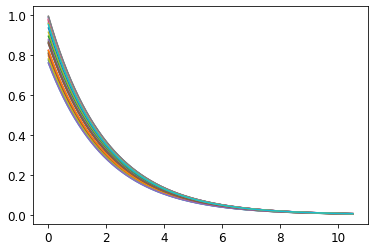

In [6]:
gamma = 0.5

pts_per_bin = 100
L_true = 10.5

ir_x = np.linspace(0, L_true, int(L_true * pts_per_bin))

# exp-decay
ir_y = np.exp(- gamma * ir_x)

# step
# step_witdh = 2
# ir_y = (ir_x < step_witdh).astype('float')

rir = randomized_ir.RandomizedIr(ir_x, ir_y, factor=lambda: 0.75 + random()*0.25)
# rir = randomized_ir.RandomizedIr(ir_x, ir_y)

rir.plot_realizations(count=30)

# Convoluted signal

Pic: `\ref{pic:problem-setup}`


In [7]:
N = 1000
n_vec_mean = 15

n_vec = generate_poissonian_ns(n_vec_mean, N)

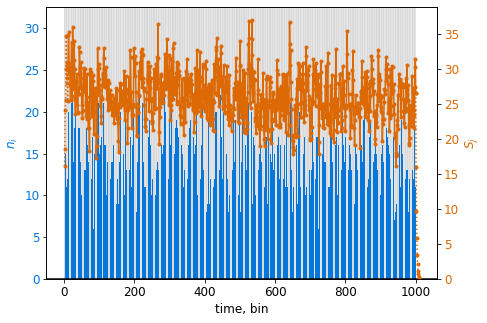

In [8]:
# uniform inbin time distribution:
S_vec = rir.convolve_with_n_vec(n_vec)

# non trivial inbin time distribution:
# S_vec = rir.convolve_with_n_vec(n_vec, inbin_invcdf=lambda x: x**(1/10), debug_inbin_times=True)

filename = 'problem-setup-example' if SAVE_IMAGES else None

plots.plot_convolution(n_vec, S_vec, filename=filename)

# Mean-based estimation

Chapter: `Грубая оценка методом наименьших квадратов`

In [9]:
stats = randomized_ir.RandomizedIrStats(rir, samplesize=100000)

n_vec_estimation = stats.estimate_n_vec(S_vec)

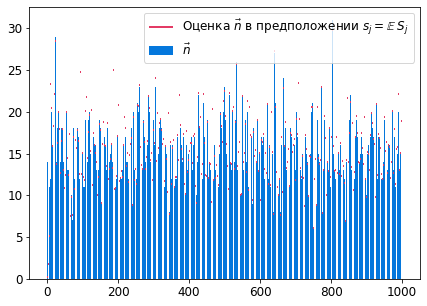

In [10]:
filename = 'mean-estimation' if SAVE_IMAGES else None
plots.plot_mean_n_estimation(n_vec, n_vec_estimation, stats.L, filename=filename)

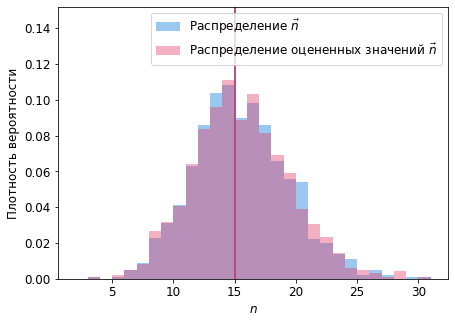

In [23]:
# save_to = 'mean-estimation-assessment'
save_to = None
plots.plot_mean_n_estimation_assessment(n_vec, n_vec_estimation, L=stats.L, filename=save_to)

Text(0.5, 0, '$n$')

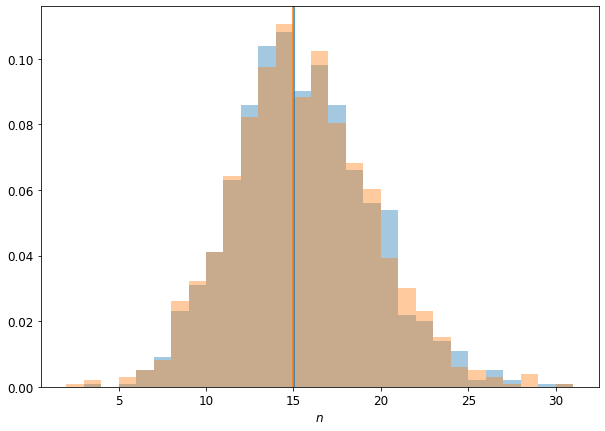

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

bin_edges = np.arange(n_vec.min()-1, n_vec.max()+1)

for data in (n_vec, np.round(n_vec_estimation)):
    _, _, histogram = ax.hist(data, bins=bin_edges, alpha=0.4, density=True)
    ax.axvline(data.mean(), color=histogram[0]._facecolor, alpha=1)

ax.set_xlabel('$n$')
ax.show()

# MCMC-based estimation

Assuming $S_j$ are close to normal

In [39]:
logL = stats.get_norm_posterior_loglikelihood(S_vec)

In [43]:
logL(n_vec_estimation)

-10.221926251101674

In [44]:
# see https://emcee.readthedocs.io/en/stable/user/sampler/

import emcee

rng = np.random.default_rng()

n_walkers = 128

spread_from_estimation = 3  # from n_vec_estimation
n_starting_points = np.tile(n_vec_estimation, (n_walkers, 1)) + rng.normal(scale=spread_from_estimation, size=(n_walkers, N))

sampler = emcee.EnsembleSampler(n_walkers, N, logL)

In [45]:
sampler.run_mcmc(n_starting_points, 300)

print('done!')

/home/njvh/Documents/Science/sphere/detector-model/deconvolution/rirenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
done!


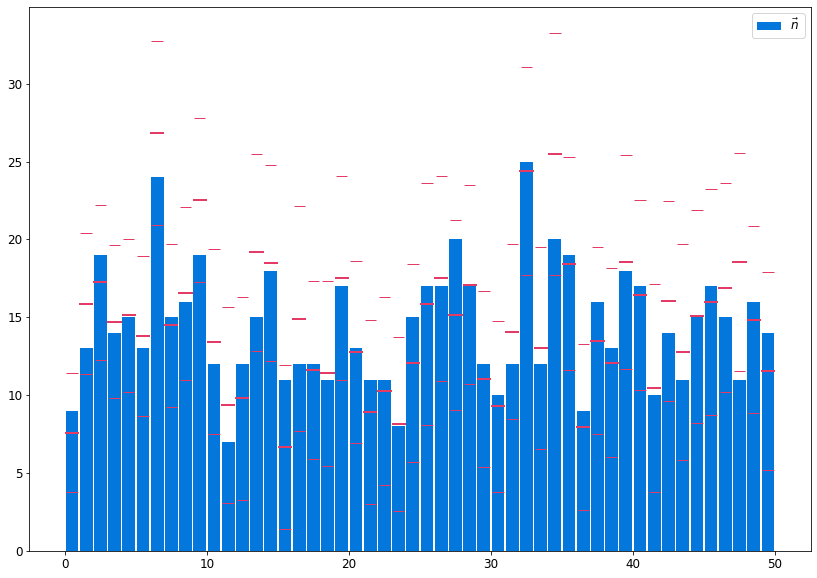

In [46]:
sample = sampler.get_chain(flat=True, thin=1, discard=100)

means = np.mean(sample, axis=0)
stds = np.std(sample, axis=0)

fig, ax = plt.subplots(figsize=(14, 10))

N_COLOR = '#0477DC'
N_ESTIMATION_COLOR = '#e33b65'

bin_centers = np.arange(N) + 0.5
ax.bar(bin_centers, n_vec, width=0.9, color=N_COLOR, label='$\\vec{n}$')
ax.hlines(
    means,
    bin_centers - 0.5,
    bin_centers + 0.5,
    colors=[N_ESTIMATION_COLOR],
    linewidths=[2],
)
std_line_halfwidth = 0.4
ax.hlines(means - stds, bin_centers - std_line_halfwidth, bin_centers + std_line_halfwidth, colors=[N_ESTIMATION_COLOR], linewidths=[1])
ax.hlines(means + stds, bin_centers - std_line_halfwidth, bin_centers + std_line_halfwidth, colors=[N_ESTIMATION_COLOR], linewidths=[1])
ax.set_ylim(bottom=0)
ax.legend()

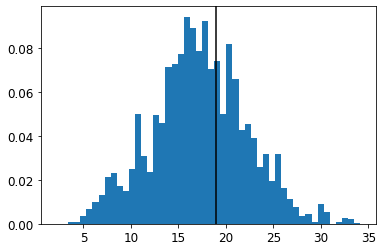

In [49]:
fig, ax =  plt.subplots()

ibin = 2

ax.hist(sample[:, ibin], bins=50, density=True)
ax.axvline(n_vec[ibin], color='black')

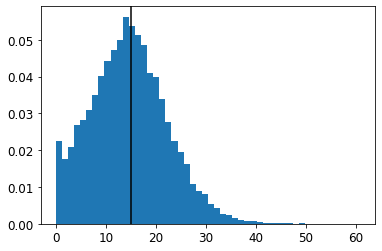

In [50]:
fig, ax =  plt.subplots()

ax.hist(np.reshape(sample, sample.size), bins=50, density=True)
ax.axvline(n_vec_mean, color='black')